In [1]:
PATH_FRC = ""

GAUSS_L2_MODEL = './gaussian_l2/models/1/'
GAUSS_FRC_MODEL = './gaussian_frc/models/1/'
GAUSS_L1_MODEL = './gaussian_l1/models/1/'

GOI_IMAGES = './google_data/test/*.jpg'

In [2]:
import os
import sys
import glob
from tqdm import tqdm

import numpy as np
import matplotlib
import pandas as pd

import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)

import skimage
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.metrics import mean_squared_error,structural_similarity
from skimage.measure import compare_psnr#, compare_ssim#, compare_mse

sys.path.append(PATH_FRC)

from dataset import create_list_dataset, process_image_single, add_noise
from models2 import FRCUnetModel
from functools import partial

import tensorflow_probability as tfp

matplotlib.rcParams.update({'mathtext.default':'regular'})
matplotlib.rcParams.update({'font.size': 8})
matplotlib.rcParams.update({'axes.labelweight': 'bold'})
matplotlib.rcParams.update({'axes.titleweight': 'bold'})

In [75]:
def normalise_img(image):
    image = image - image.min()
    image = image/image.max() - 0.5
    return image

def load_data(DATA_LOCATION, resize=True):
    clean_images=[]
    for file in sorted(glob.glob(DATA_LOCATION)):
        clean = imread(file)
        if len(clean.shape) > 2:
            clean = np.mean(clean, axis=2)
        if resize:
            minsize = np.array(clean.shape).min()
            clean = clean[:minsize,:minsize]
            clean=tf.convert_to_tensor(clean)
            clean=clean[tf.newaxis, ..., tf.newaxis]
            clean=tf.image.resize(
            clean, [256,256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR, \
                preserve_aspect_ratio=True, antialias=False, name=None)
            clean=clean.numpy().squeeze()
        clean = normalise_img(clean)
        clean = clean.astype('float32')
        clean_images.append(clean)
    return clean_images

def load_model(model_dir, model_fname):
    if model_dir is not None:
        return FRCUnetModel(None, model_path=os.path.join(model_dir, model_fname))

def fourier_ring_correlation_by_ring(image1, image2, rn, spatial_freq):
    # we need the channels first format for this loss
    image1 = tf.transpose(image1, perm=[0, 3, 1, 2])
    image2 = tf.transpose(image2, perm=[0, 3, 1, 2])
    image1 = tf.cast(image1, tf.complex64)
    image2 = tf.cast(image2, tf.complex64)
    rn = tf.cast(rn, tf.complex64)
    fft_image1 = tf.signal.fftshift(tf.signal.fft2d(image1), axes=[2, 3])
    fft_image2 = tf.signal.fftshift(tf.signal.fft2d(image2), axes=[2, 3])

    t1 = tf.multiply(fft_image1, rn)  # (128, BS?, 3, 256, 256)
    t2 = tf.multiply(fft_image2, rn)
    c1 = tf.math.real(tf.reduce_sum(tf.multiply(t1, tf.math.conj(t2)), [2, 3, 4]))
    c2 = tf.reduce_sum(tf.math.abs(t1) ** 2, [2, 3, 4])
    c3 = tf.reduce_sum(tf.math.abs(t2) ** 2, [2, 3, 4])
    frc = tf.math.divide(c1, tf.math.sqrt(tf.math.multiply(c2, c3)))
    frc = tf.where(tf.compat.v1.is_inf(frc), tf.zeros_like(frc), frc)  # inf
    frc = tf.where(tf.compat.v1.is_nan(frc), tf.zeros_like(frc), frc)  # nan
    
    riemann_sum = tf.reduce_sum(tf.multiply(spatial_freq[1:] - spatial_freq[:-1], (frc[:-1] + frc[1:]) / 2.), 0)
    return frc.numpy().T[0], riemann_sum.numpy()[0]
 
def get_stats(model, image, noisy_image,radial_masks, spatial_freq):
    
    denoised = model(np.reshape(noisy_image, [1,256, 256,1]))
    denoised = model.scale(denoised) - 0.5
    mse = mean_squared_error(np.squeeze(image), np.squeeze(denoised))
    ssim = structural_similarity(np.squeeze(image), np.squeeze(denoised))
    frc_by_ring, frc = fourier_ring_correlation_by_ring(np.reshape(image, [1,256, 256,1]),\
                                                np.reshape(denoised, [1,256, 256,1]), 
                                         radial_masks, spatial_freq)
    
    return denoised, mse, ssim, frc, frc_by_ring

def process_set(im_data,L2_MODEL,FRC_MODEL,L1_MODEL,model_names,\
                noise_model='lognormal', im_data_odd=None):
    results = [[],[],[]]

    for a,model_name in tqdm(enumerate(model_names[:])):
        mse_model = load_model(L2_MODEL, model_name)
        frc_model = load_model(FRC_MODEL, model_name)
        mae_model = load_model(L1_MODEL, model_name)
        if a == 0:
            radial_masks,spatial_freq = mse_model.radial_masks, mse_model.spatial_freq
        mse_stats,frc_stats,mae_stats = [],[],[]

        for idx, image in enumerate(im_data):
            if noise_model == 'lognormal':
                noise=np.random.lognormal(0,1.3,256**2).reshape(256,256) -1
                noisy_image=im_data[idx]+noise
            elif noise_model == 'normal':
                noise=np.random.normal(0,0.4,256**2).reshape(256,256)
                noisy_image=im_data[idx]+noise
            elif noise_model == None:
                noisy_image = im_data_odd[idx]
                        

            mse_stats.append(get_stats(mse_model, image, noisy_image,radial_masks,spatial_freq)[-1])
            mae_stats.append(get_stats(mae_model, image, noisy_image,radial_masks,spatial_freq)[-1])
            frc_stats.append(get_stats(frc_model, image, noisy_image,radial_masks,spatial_freq)[-1])
        
        results[0].append(mse_stats)
        results[1].append(mae_stats)
        results[2].append(frc_stats)
    return results

In [4]:
goi_test_images = load_data(GOI_IMAGES)
model_names = ['saved-model-batch-{}'.format(idx) for idx in [2 ** x for x in range(20)]]

In [76]:
#Expensive loop, mostly because of slow model loading, and we load here hundreds of models
gaussian_noise = process_set(goi_test_images,GAUSS_L2_MODEL,GAUSS_FRC_MODEL,GAUSS_L1_MODEL,model_names[:],\
                noise_model='normal')

20it [17:45, 53.29s/it]


In [77]:
average_gaussian_noise = np.array(gaussian_noise,dtype=object)
average_gaussian_noise = average_gaussian_noise.mean(axis=2)

In [78]:
average_gaussian_noise.shape

(3, 20, 128)

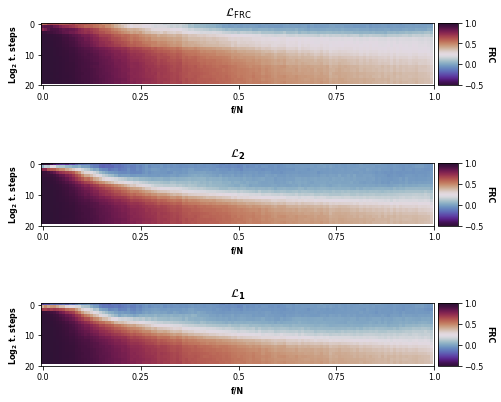

In [80]:
from matplotlib import ticker, cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

levels = np.arange(-1.0, 1.01, 0.5)
lx=['0.0', '0.25', '0.5', '0.75', '1.0']

fig = plt.figure(figsize=(7, 6))
ax1 = fig.add_subplot(311)
im=ax1.imshow(average_gaussian_noise[2,:,:].astype('float'), cmap='twilight_shifted',vmin=-0.5, vmax=1.0)
ax1.set_title(r'$\mathcal{L}_{\mathrm{FRC}}$', size=12)
plt.ylabel(r'$Log_2$ t. steps')
ax1.set_xlabel('f/N')
#ax1.set_xticklabels(lx)
plt.xticks(np.arange(0,129, 32), lx)#, rotation='vertical')
plt.yticks(np.arange(0,21, 10), ['0','10','20'])#, rotation='vertical')

divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.05)
cax = divider.new_horizontal(size="5%", pad=0.05)
fig = ax1.get_figure()
fig.add_axes(cax)

#plt.clim(0, 1.0)
cbar = plt.colorbar(im, ticks=levels ,cax=cax)
cbar.set_label(r'FRC', rotation=270,labelpad=10)


ax2 = fig.add_subplot(312)
im=ax2.imshow(average_gaussian_noise[0,:,:].astype('float'), cmap='twilight_shifted',vmin=-0.5, vmax=1.0)
ax2.set_title(r'$\mathcal{L}_{2}$', size=12)
ax2.set_xlabel('f/N')
plt.xticks(np.arange(0,129, 32), lx)#, rotation='vertical')
plt.yticks(np.arange(0,21, 10), ['0','10','20'])#, rotation='vertical')

plt.ylabel(r'$Log_2$ t. steps')
#plt.text(0.0, 0.5, 'Training steps', rotation=90)

divider = make_axes_locatable(ax2)
#cax = divider.append_axes("right", size="5%", pad=0.05)
cax = divider.new_horizontal(size="5%", pad=0.05)
fig = ax2.get_figure()
fig.add_axes(cax)

#plt.clim(0, 1.0)
cbar = plt.colorbar(im, ticks=levels ,cax=cax)
cbar.set_label(r'FRC', rotation=270,labelpad=10)
cbar.vmax=1.0
cbar.vmin=0
#cbar.set_ticks([0,0.5,1.0])

ax3 = fig.add_subplot(313)
im=ax3.imshow(average_gaussian_noise[1,:,:].astype('float'), cmap='twilight_shifted',vmin=-0.5, vmax=1.0)
ax3.set_title(r'$\mathcal{L}_{1}$', size=12)


labels = [item.get_text() for item in ax3.get_xticklabels()]
plt.ylabel(r'$Log_2$ t. steps')
ax3.set_xlabel('f/N')
plt.xticks(np.arange(0,129, 32), lx)#, rotation='vertical')
plt.yticks(np.arange(0,21, 10), ['0','10','20'])#, rotation='vertical')


divider = make_axes_locatable(ax3)
#cax = divider.append_axes("right", size="5%", pad=0.05)
cax = divider.new_horizontal(size="5%", pad=0.05)
fig = ax3.get_figure()
fig.add_axes(cax)

#plt.clim(0, 1.0)

cbar = plt.colorbar(im,ticks=levels,cax=cax)
cbar.set_label(r'FRC', rotation=270,labelpad=10)


fig.tight_layout()

fig.savefig('figure_s2.png', dpi=300) # dpi 300-200